In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import tensorflow as tf

In [ ]:
tf.__version__

'2.6.0'

In [ ]:
!unzip "/content/drive/MyDrive/datasets/image segmentation/data.zip" -d internal

Streaming output truncated to the last 5000 lines.
  inflating: internal/data/images/377/frame28480_leftImg8bit.jpg  
  inflating: internal/data/images/377/frame28699_leftImg8bit.jpg  
  inflating: internal/data/images/377/frame28808_leftImg8bit.jpg  
  inflating: internal/data/images/377/frame29080_leftImg8bit.jpg  
  inflating: internal/data/images/377/frame29271_leftImg8bit.jpg  
  inflating: internal/data/images/377/frame29435_leftImg8bit.jpg  
  inflating: internal/data/images/377/frame29653_leftImg8bit.jpg  
  inflating: internal/data/images/377/frame29817_leftImg8bit.jpg  
  inflating: internal/data/images/377/frame30062_leftImg8bit.jpg  
  inflating: internal/data/images/377/frame30199_leftImg8bit.jpg  
  inflating: internal/data/images/377/frame3039_leftImg8bit.jpg  
  inflating: internal/data/images/377/frame30417_leftImg8bit.jpg  
  inflating: internal/data/images/377/frame30499_leftImg8bit.jpg  
  inflating: internal/data/images/377/frame30608_leftImg8bit.jpg  
  inflating:

# 01. UNET Preprocessing

## 1. Get all files in dataframe

In [ ]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    image_path = [os.path.join(r,file) for r,d,f in os.walk(root_dir + "/images") for file in f]
    json_path = [os.path.join(r,file) for r,d,f in os.walk(root_dir + "/mask") for file in f]
    image_path = list(np.sort(image_path))
    json_path = list(np.sort(json_path))
    data_df = pd.DataFrame({"image":image_path, "json":json_path})
    return data_df

root_dir = "internal/data"
data_df = return_file_names_df(root_dir)
data_df.head()

image                                               json
0  internal/data/images/201/frame0029_leftImg8bit...  internal/data/mask/201/frame0029_gtFine_polygo...
1  internal/data/images/201/frame0299_leftImg8bit...  internal/data/mask/201/frame0299_gtFine_polygo...
2  internal/data/images/201/frame0779_leftImg8bit...  internal/data/mask/201/frame0779_gtFine_polygo...
3  internal/data/images/201/frame1019_leftImg8bit...  internal/data/mask/201/frame1019_gtFine_polygo...
4  internal/data/images/201/frame1469_leftImg8bit...  internal/data/mask/201/frame1469_gtFine_polygo...

In [ ]:
data_df.shape

(4008, 2)

## 2. Read Json file - get unique labels

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    unique_labels_li = []
    jsons = data_df.json.values
    for file_ in jsons:
      f = open(file_)
      data = json.load(f)
      unique_labels_li = unique_labels_li+[data["objects"][i]["label"] for i in range(len(data["objects"]))]
      
    unique_labels = list(set(unique_labels_li))
    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                        'train':200}

In [ ]:
# grader 2
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("False")

grader_2(unique_labels)

True


## 03. Extract polygons from JSON files

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    label = []
    vertexlist = []
    f = open(file)
    data = json.load(f)
    label = label + [data["objects"][i]["label"] for i in range(len(data["objects"]))]

    for i in range(len(data["objects"])):
      # print([tuple(elem) for elem in data["objects"][i]["polygon"]])
      # print("="*100)
      vertexlist.append([tuple(elem) for elem in data["objects"][i]["polygon"]])

    h = data["imgHeight"]
    w = data["imgWidth"]
    f.close()

    return w, h, label, vertexlist

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('internal/data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

In [ ]:
import re
from tqdm import tqdm
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths

    w = 1920
    h = 1080
    labels = []
    vertexlist = []
    framenumber = []
    scenenumber = []
    mask_path=[]

    # compute vertexlist
    for i in tqdm(range(len(data_df.json.values))):
      w, h, l, v = get_poly(data_df.json.values[i])
      labels.append(l)
      vertexlist.append(v)
      framenumber.append(data_df.json.values[i][23:data_df.json.values[i][:].find('_')])
      scenenumber.append(re.findall('(\d+)', data_df.json.values[i])[0])

    # draw image masks using polygon coordinates
    for j in tqdm(range(len(labels))):
      img = Image.new("RGB", (w,h))
      img1 = ImageDraw.Draw(img)
      # print(len(labels[j]), labels[j])
      for k in range(len(labels[j])):
        # print(vertexlist[j][k])
        # print(labels[j][k], label_clr[labels[j][k]])
        try:
          img1.polygon(vertexlist[j][k], fill = label_clr[labels[j][k]])
        except Exception as e:
          print(e)
      img=np.array(img)
      im = Image.fromarray(img[:,:,0])

      # create directory is it does not exist
      directory = "internal/data/output/"+scenenumber[j]+"/"
      if not os.path.exists(directory):
        os.makedirs(directory)
      im.save(os.path.join(directory+framenumber[j]+"_gtFine_polygons.png"))
      mask_path.append(directory+framenumber[j]+"_gtFine_polygons.png")

    # save to df
    data_df["mask"] = mask_path
    
    return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

 45%|████▌     | 1805/4008 [01:48<02:05, 17.55it/s]

coordinate list must contain at least 2 coordinates


 47%|████▋     | 1867/4008 [01:52<01:45, 20.24it/s]

coordinate list must contain at least 2 coordinates
coordinate list must contain at least 2 coordinates
coordinate list must contain at least 2 coordinates
coordinate list must contain at least 2 coordinates


 56%|█████▌    | 2229/4008 [02:14<01:52, 15.76it/s]

coordinate list must contain at least 2 coordinates


 65%|██████▍   | 2594/4008 [02:35<01:27, 16.24it/s]

coordinate list must contain at least 2 coordinates
coordinate list must contain at least 2 coordinates


 67%|██████▋   | 2683/4008 [02:40<01:20, 16.37it/s]

coordinate list must contain at least 2 coordinates
coordinate list must contain at least 2 coordinates
coordinate list must contain at least 2 coordinates


 87%|████████▋ | 3495/4008 [03:27<00:32, 15.95it/s]

coordinate list must contain at least 2 coordinates


100%|██████████| 4008/4008 [03:58<00:00, 16.82it/s]


image  ...                                               mask
0  internal/data/images/201/frame0029_leftImg8bit...  ...  internal/data/output/201/frame0029_gtFine_poly...
1  internal/data/images/201/frame0299_leftImg8bit...  ...  internal/data/output/201/frame0299_gtFine_poly...
2  internal/data/images/201/frame0779_leftImg8bit...  ...  internal/data/output/201/frame0779_gtFine_poly...
3  internal/data/images/201/frame1019_leftImg8bit...  ...  internal/data/output/201/frame1019_gtFine_poly...
4  internal/data/images/201/frame1469_leftImg8bit...  ...  internal/data/output/201/frame1469_gtFine_poly...

[5 rows x 3 columns]

True
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


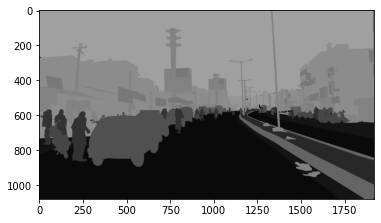

In [ ]:
# grader 3
import requests
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('internal/data/output/201/frame0029_gtFine_polygons.png')    
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

# 02. Applying U net

## 1. Data Processing - splitting the data into train and test

In [ ]:
# read the data file
# data_df = pd.read_csv("/content/drive/MyDrive/datasets/image segmentation/preprocessed_data (1).csv")

In [ ]:
data_df.head()

image  ...                                               mask
0  internal/data/images/201/frame0029_leftImg8bit...  ...  internal/data/output/201/frame0029_gtFine_poly...
1  internal/data/images/201/frame0299_leftImg8bit...  ...  internal/data/output/201/frame0299_gtFine_poly...
2  internal/data/images/201/frame0779_leftImg8bit...  ...  internal/data/output/201/frame0779_gtFine_poly...
3  internal/data/images/201/frame1019_leftImg8bit...  ...  internal/data/output/201/frame1019_gtFine_poly...
4  internal/data/images/201/frame1469_leftImg8bit...  ...  internal/data/output/201/frame1469_gtFine_poly...

[5 rows x 3 columns]

In [ ]:
# Split the data
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_df, test_size=0.1, random_state=101)

In [ ]:
train_data.shape, test_data.shape

((3607, 3), (401, 3))

In [ ]:
def process_data(df):
  '''
  Custom function that outputs a list of images and masks
  '''
  image_paths = [x for x in df.image]
  mask_paths = [x for x in df["mask"]]
  return image_paths, mask_paths

In [ ]:
train_x, train_y = process_data(train_data)
test_x, test_y = process_data(test_data)
len(train_x), len(train_y), len(test_x), len(test_y)

(3607, 3607, 401, 401)

## 2. Downloading the unet model

In [ ]:
!pip install -U segmentation-models

import imgaug.augmenters as iaa

     |████████████████████████████████| 50 kB 5.3 MB/s 


In [ ]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models import Unet
import tensorflow as tf
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


In [ ]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
model = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='softmax', input_shape=(512,512,3), encoder_freeze=True)

85532672/85521592 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

## 3. Creating the data pipeline - dataset and dataloader

In [ ]:
# import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
import imgaug.augmenters as iaa

aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap="gray")
    plt.show()
    
def normalize_image(mask):
    mask = mask/255
    return mask

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    # CLASSES = ['road', 'parking', 'sidewalk', 'rail track', 'person', 'animal', 'rider', 'motorcycle',
    #             'car', 'truck', 'curb', 'fence', 'billboard', 'pole', 'building', 'vegetation',
    #             'sky', 'ego vehicle', 'ground', 'rectification border', 'train']
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, images_dir, masks_dir, classes, trigger):
        
        self.ids = images_dir
        self.trigger = trigger
        # print(self.ids)
        # the paths of images
        self.images_fps   = images_dir
        # the paths of segmentation images
        self.masks_fps    = masks_dir
        # giving labels for each class
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        # self.class_values = [label_clr[cls] for cls in classes]
        self.class_values = classes
        # print(self.class_values)
    
    def __getitem__(self, i):
        
        # read data for images and mask and resize
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (512,512), interpolation=cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image/255.0
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask, (512,512), interpolation=cv2.INTER_NEAREST)
        # image_mask = normalize_image(mask)
        image_mask = mask

        
        image_masks = [(image_mask == v) for v in self.class_values]
        # print(image_masks)
        image_mask = np.stack(image_masks, axis=-1).astype('float')

        if self.trigger == "train":
          a = np.random.uniform()
          if a<0.2:
              image = aug2.augment_image(image)
              image_mask = aug2.augment_image(image_mask)
          elif a<0.4:
              image = aug3.augment_image(image)
              image_mask = aug3.augment_image(image_mask)
          elif a<0.6:
              image = aug4.augment_image(image)
              image_mask = aug4.augment_image(image_mask)
          elif a<0.8:
              image = aug5.augment_image(image)
              image_mask = image_mask
          else:
              image = aug6.augment_image(image)
              image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

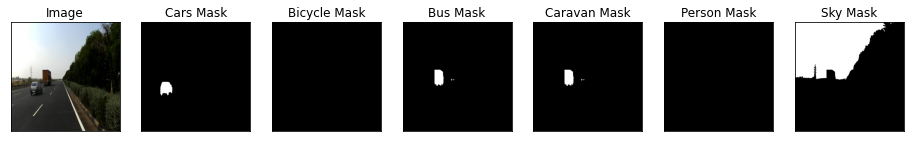

In [ ]:
# # Lets look at data we have
# dataset = Dataset(train_x, train_y, classes=['car', 'bicycle', 'bus', 'caravan', 'person', "sky"], trigger="test")

# image, mask = dataset[665] # get some sample
# visualize(
#     image=image, 
#     cars_mask=mask[..., 0].squeeze(),
#     bicycle_mask=mask[..., 1].squeeze(),
#     bus_mask=mask[..., 2].squeeze(),
#     caravan_mask=mask[..., 3].squeeze(),
#     person_mask=mask[..., 4].squeeze(),
#     sky_mask=mask[..., 5].squeeze()
# )

# Lets look at data we have
dataset = Dataset(train_x, train_y, classes=[80,70,90,90,50,160], trigger="test")

image, mask = dataset[254] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    bicycle_mask=mask[..., 1].squeeze(),
    bus_mask=mask[..., 2].squeeze(),
    caravan_mask=mask[..., 3].squeeze(),
    person_mask=mask[..., 4].squeeze(),
    sky_mask=mask[..., 5].squeeze()
)

In [ ]:
# initializing all necessary parameters
CLASSES = [0, 130, 10, 140, 20, 150, 30, 160, 40, 170, 50, 180, 60, 190, 70, 200, 80, 90, 100, 110, 120]

BATCH_SIZE = 4
EPOCHS = 15

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    train_x, 
    train_y, 
    classes=CLASSES, 
    trigger="train",
)

# Dataset for validation images
valid_dataset = Dataset(
    test_x,
    test_y,
    classes=CLASSES, 
    trigger="test",
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=2, shuffle=True)

In [ ]:
train_dataloader[0][0].shape, train_dataloader[0][1].shape, valid_dataloader[0][0].shape, valid_dataloader[0][1].shape

((4, 512, 512, 3), (4, 512, 512, 21), (2, 512, 512, 3), (2, 512, 512, 21))

## 4. Training the model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

optim = tf.keras.optimizers.Adam(0.0001)

# focal_loss = sm.losses.cce_dice_loss
# focal_loss = sm.losses.DiceLoss()
total_loss = sm.losses.categorical_focal_dice_loss 

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, loss=total_loss, metrics=[sm.metrics.IOUScore(threshold=0.5)])

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/datasets/image segmentation/best_model.h5', save_weights_only=False, save_best_only=True, \
                                       mode='max', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2),
]

In [ ]:
# # # load last saved model from the previous day
# model = tf.keras.models.load_model('/content/drive/MyDrive/datasets/image segmentation/best_model.h5', 
#                                    custom_objects={'focal_loss_plus_dice_loss': sm.losses.categorical_focal_dice_loss,
#                                                    'iou_score': sm.metrics.IOUScore()})

In [ ]:
# train model
history = model.fit_generator(
                              train_dataloader, 
                              steps_per_epoch=len(train_dataloader), 
                              epochs=10, 
                              callbacks=callbacks, 
                              validation_data=valid_dataloader, 
                              validation_steps=len(valid_dataloader),
                          )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
901/901 [==============================] - 665s 738ms/step - loss: 0.5844 - iou_score: 0.5758 - val_loss: 0.6326 - val_iou_score: 0.5562


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
901/901 [==============================] - 662s 735ms/step - loss: 0.5856 - iou_score: 0.5744 - val_loss: 0.6318 - val_iou_score: 0.5559
Epoch 3/10
901/901 [==============================] - 671s 745ms/step - loss: 0.5850 - iou_score: 0.5749 - val_loss: 0.6306 - val_iou_score: 0.5575
Epoch 4/10
901/901 [==============================] - 685s 759ms/step - loss: 0.5836 - iou_score: 0.5770 - val_loss: 0.6316 - val_iou_score: 0.5568
Epoch 5/10
901/901 [==============================] - 667s 740ms/step - loss: 0.5836 - iou_score: 0.5761 - val_loss: 0.6305 - val_iou_score: 0.5579
Epoch 6/10
901/901 [==============================] - 674s 747ms/step - loss: 0.5826 - iou_score: 0.5774 - val_loss: 0.6306 - val_iou_score: 0.5577
Epoch 7/10
901/901 [==============================] - 672s 745ms/step - loss: 0.5802 - iou_score: 0.5808 - val_loss: 0.6293 - val_iou_score: 0.5585
Epoch 8/10
901/901 [==============================] - 672s 745ms/step - loss: 0.5817 - iou_score: 0.5787 - val_l

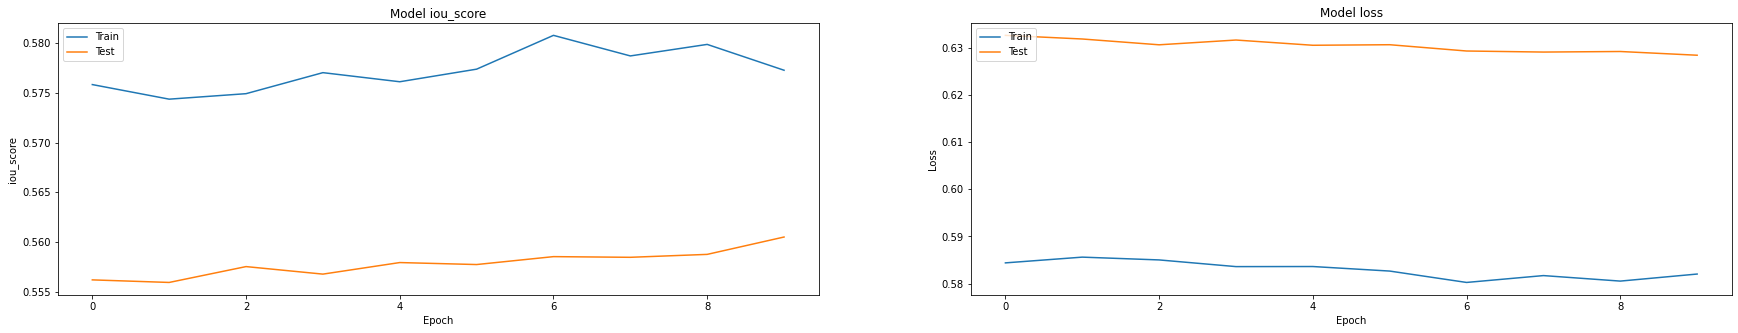

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 5. Dice Loss

- What is Dice Loss?
 - Dice Loss is a popular loss function for image segmentation tasks, also referred to as the dice coefficient. It is essentially a measure of overlap between two samples.

- Formulation
 - 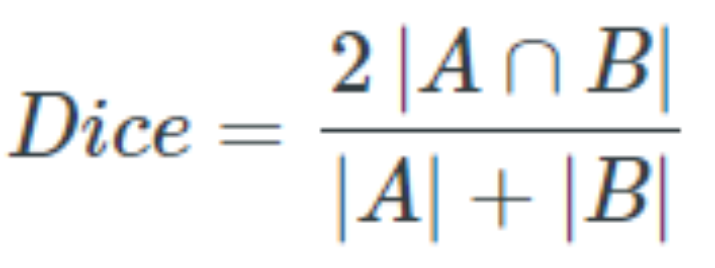

 - Range of loss function?
  - Range is between 0 to 1

- Interpretation of the loss function?
 - 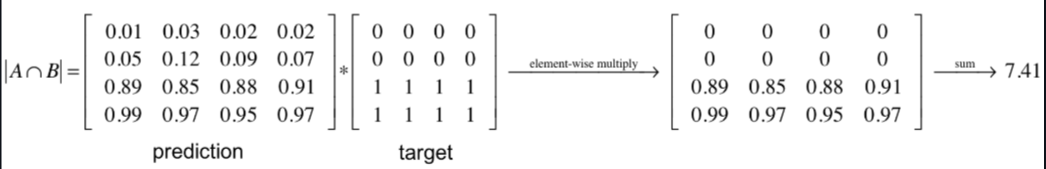
 - For the case of evaluating a Dice coefficient on predicted segmentation masks, we can approximate 
|
A
∩
B
|
 as the element-wise multiplication between the prediction and target mask and then sum the resulting matrix. This loss function helps us to determine how much loss is encountered in each pixel and how accurate our model is performing per pixel. Then the overall sum can be taken to show the complete loss from a target model to the predicted model after segmentation is performed.

## 6. Final prediction

In [ ]:
# loading the last saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/datasets/image segmentation/best_model_latest.h5', 
                                   custom_objects={'focal_loss_plus_dice_loss': sm.losses.categorical_focal_dice_loss,
                                                   'iou_score': sm.metrics.IOUScore(threshold=0.5)})

In [ ]:
metrics=[sm.metrics.IOUScore(threshold=0.5)]
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss: 0.62837
mean iou_score: 0.56049


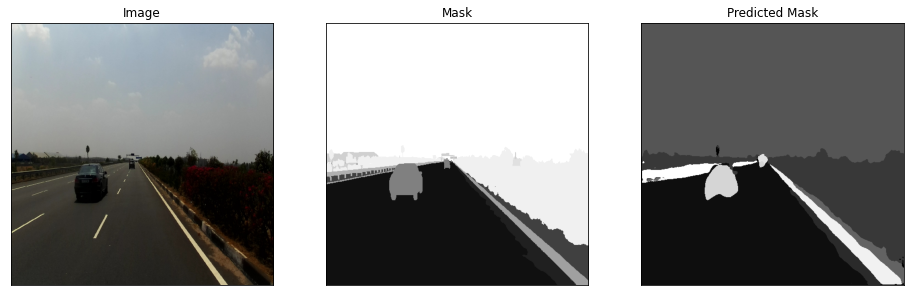

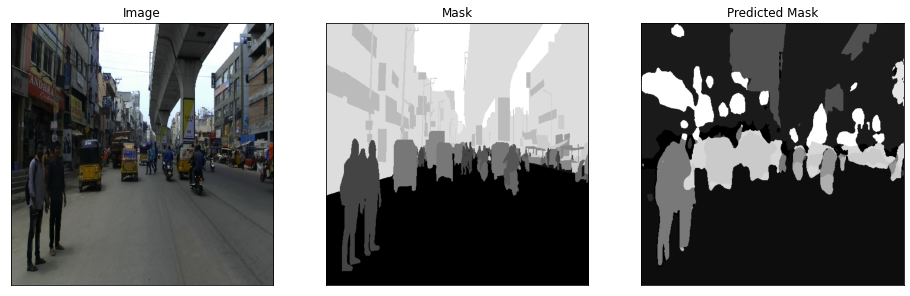

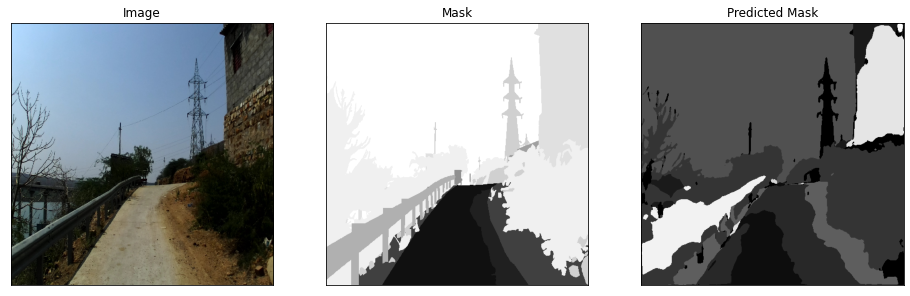

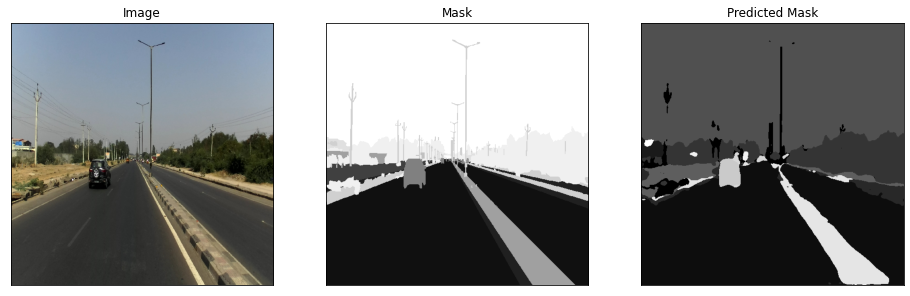

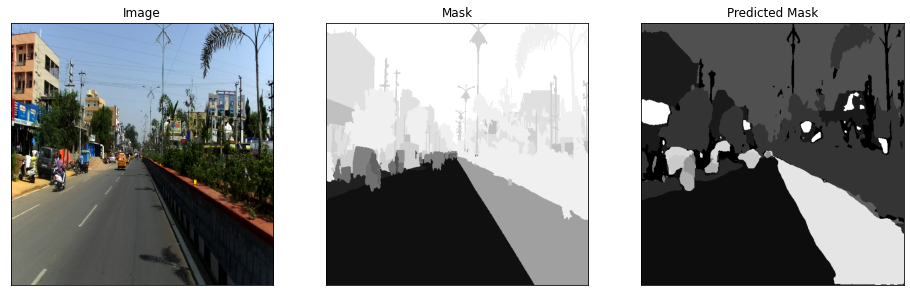

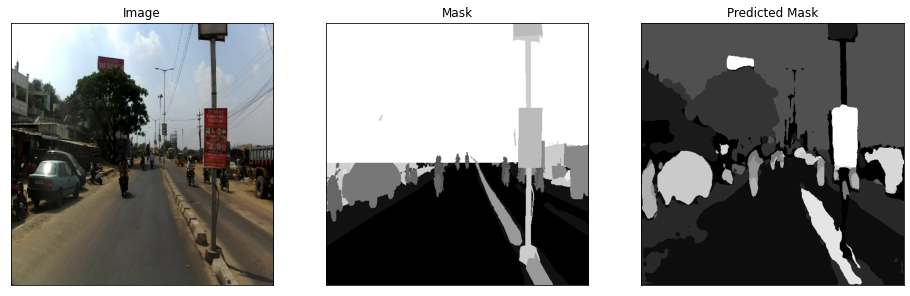

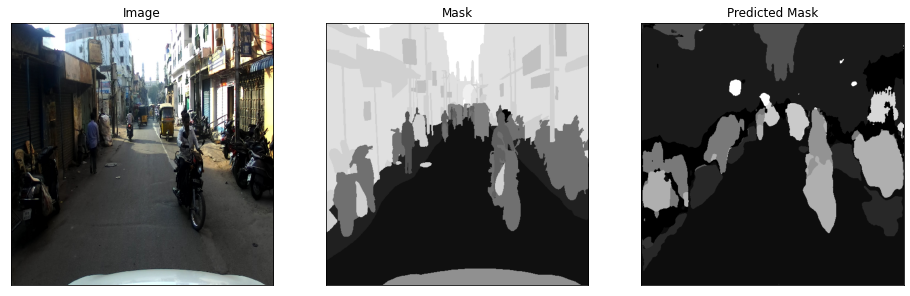

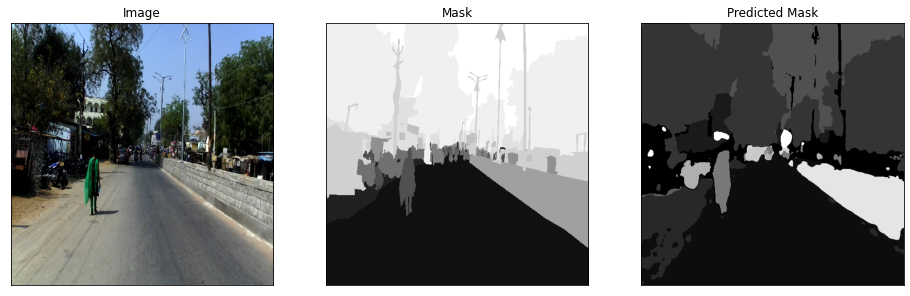

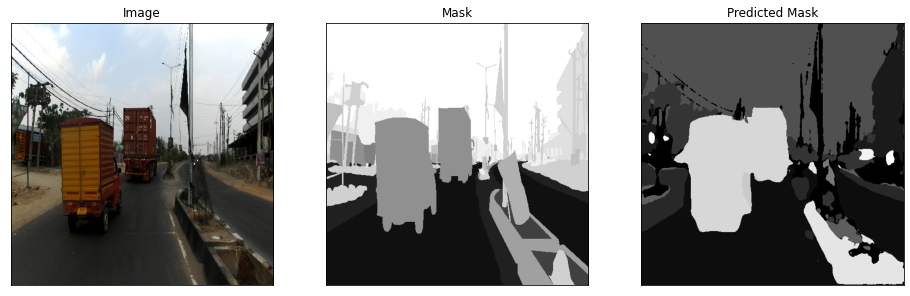

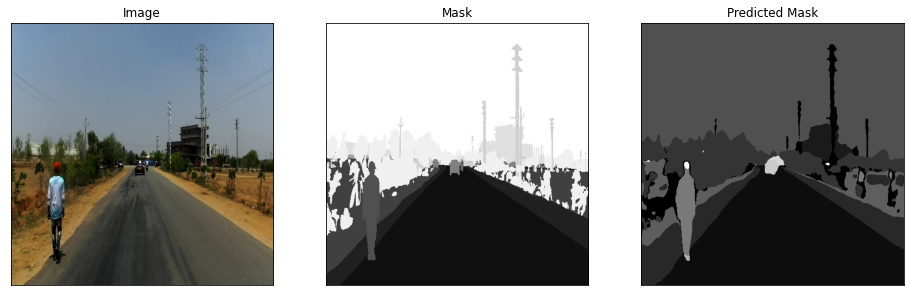

In [ ]:
x = test_x[:10] 
y = test_y[:10]
for i in range(len(x)): 
  #original image
  image = cv2.imread(x[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (512,512), interpolation=cv2.INTER_NEAREST)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = image/255.0

  #predicted segmentation map
  predicted  = model.predict(image[np.newaxis,:,:,:])
  predicted = np.argmax(predicted, axis=-1)
  predicted = np.expand_dims(predicted, axis=-1)
  # print(predicted.shape)
  
  #original segmentation map
  mask = cv2.imread(y[i], 0)
  mask = cv2.resize(mask, (512,512), interpolation=cv2.INTER_NEAREST)
  # print(mask.shape)

  visualize(
    image=image, 
    mask=mask,
    predicted_mask=predicted[..., 0].squeeze()
  )

# 03. CANet
#### credits: https://blog.paperspace.com/understanding-canet-architecture/

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv block"):
        super().__init__(convolutional_block)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        
        self.conv_1 = Conv2D(self.F1,(1,1),strides=(self.stride,self.stride),padding='same')
        self.conv_2 = Conv2D(self.F2,(self.kernel,self.kernel),strides=(1,1),padding='same')
        self.conv_3 = Conv2D(self.F3,(1,1),strides=(1,1),padding='same')
        self.conv_4 = Conv2D(self.F3,(self.kernel,self.kernel),strides=(self.stride,self.stride),padding='same')
        
        self.bn1 = BatchNormalization(axis=3)
        self.bn2 = BatchNormalization(axis=3)
        self.bn3 = BatchNormalization(axis=3)
        self.bn4 = BatchNormalization(axis=3)
        
        self.activation = Activation("relu")
        
        self.add = Add()

    def get_config(self):
        config  = super().get_config().copy()
        config .update({
                        "F1":self.F1,
                        "F2":self.F2,
                        "F3":self.F3,
                        "kernel":self.kernel,
                        "stride":self.stride,
                        "conv_1":self.conv_1,
                        "conv_2":self.conv_2,
                        "conv_3":self.conv_3,
                        "conv_4":self.conv_4,
                        "bn1":self.bn1,
                        "bn2":self.bn2,
                        "bn3":self.bn3,
                        "bn4":self.bn4,
                        "activation":self.activation,
                        "add":self.add
                        })
        return config  
        
    def call(self, X):
        # write the architecutre that was mentioned above
        
        X_input = X
        
        # First Convolutional Block
        
        conv1 = self.conv_1(X)
        bn1 = self.bn1(conv1)
        act1 = self.activation(bn1)
        
        # Second Convolutional Block
        
        conv2 = self.conv_2(act1)
        bn2 = self.bn2(conv2)
        act2 = self.activation(bn2)
        
        # Third Convolutional Block
        
        conv3 = self.conv_3(act2)
        bn3 = self.bn3(conv3)
        
        # Adjusting the input
        
        X_input = self.conv_4(X_input)
        X_input = self.bn4(X_input)
        X_input = self.activation(X_input)
        
        # Re-add the input
        
        X = self.add([bn3, X_input])
        X = self.activation(X)
        
        return X

In [ ]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity block"):
        super().__init__(identity_block)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        
        self.conv_1 = Conv2D(self.F1, (1,1), (1,1), padding="same")
        self.conv_2 = Conv2D(self.F2, (self.kernel,self.kernel), (1,1), padding="same")
        self.conv_3 = Conv2D(self.F3, (1,1), (1,1), padding="same")
        
        self.bn1 = BatchNormalization(axis=3)
        self.bn2 = BatchNormalization(axis=3)
        self.bn3 = BatchNormalization(axis=3)
        
        self.activation = Activation("relu")
        
        self.add = Add()

    # def get_config(self):
    #     cfg = super().get_config().copy()
    #     cfg.update({
    #         "F1":self.F1,
    #         "F2":self.F2,
    #         "F3":self.F3,
    #         "kernel":self.kernel,
    #         "conv_1":self.conv_1,
    #         "conv_2":self.conv_2,
    #         "conv_3":self.conv_3,
    #         "bn1":self.bn1,
    #         "bn2":self.bn2,
    #         "bn3":self.bn3,
    #         "activation":self.activation,
    #         "add":self.add
    #         })
    #     return cfg  
        
    def call(self, X):
        # write the architecutre that was mentioned above
        
        X_input = X
        
        conv1 = self.conv_1(X)
        bn1 = self.bn1(conv1)
        act1 = self.activation(bn1)
        
        conv2 = self.conv_2(act1)
        bn2 = self.bn2(conv2)
        act2 = self.activation(bn2)
        
        conv3 = self.conv_3(act2)
        bn3 = self.bn3(conv3)
        
        X = self.add([bn3, X_input])
        X = self.activation(X)
        
        
        return X

In [ ]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, channels, name="global_flow"):
        super().__init__(global_flow)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.channels = channels
        
        self.conv1 = Conv2D(64,kernel_size=(1,1),strides=(1,1),padding='same')
        self.global_avg_pool = GlobalAveragePooling2D()
        self.bn = BatchNormalization(axis=3)
        self.activation = Activation("relu")
        self.upsample = UpSampling2D(size=(self.input_dim,self.output_dim),interpolation='bilinear')

    # def get_config(self):
    #     cfg = super().get_config().copy()
    #     cfg.update({
    #         "input_dim":self.input_dim,
    #         "output_dim":self.output_dim,
    #         "channels":self.channels,
    #         "conv_1":self.conv_1,
    #         "global_avg_pool":self.global_avg_pool,
    #         "bn":self.bn,
    #         "activation":self.activation,
    #         "upsample":self.upsample
    #         })
    #     return cfg 

    def call(self, X):
        # implement the global flow operatiom
        
        global_avg = self.global_avg_pool(X)
        
        global_avg= tf.expand_dims(global_avg, 1)
        global_avg = tf.expand_dims(global_avg, 1)
        
        bn1 = self.bn(global_avg)
        act1 = self.activation(bn1)
        
        conv1 = self.conv1(act1)
        
        X = self.upsample(conv1)
        
        return X

In [ ]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(context_flow)
        
        self.conv_1 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")
        self.conv_2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")
        self.conv_3 = Conv2D(64, kernel_size=(1,1), strides=(1,1), padding="same")
        self.conv_4 = Conv2D(64, kernel_size=(1,1), strides=(1,1), padding="same")
        
        self.concatenate = Concatenate()
        
        self.avg_pool = AveragePooling2D(pool_size=(2,2))
        
        self.activation_relu = Activation("relu")
        self.activation_sigmoid = Activation("sigmoid")
        
        self.add = Add()
        self.multiply = Multiply()
        
        self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear') 
        
    # def get_config(self):
    #     cfg = super().get_config().copy()
    #     cfg.update({
    #         "conv_1":self.conv_1,
    #         "conv_2":self.conv_2,
    #         "conv_3":self.conv_3,
    #         "conv_4":self.conv_4,
    #         "concatenate":self.concatenate,
    #         "avg_pool":self.avg_pool,
    #         "activation_relu":self.activation_relu,
    #         "activation_sigmoid":self.activation_sigmoid,
    #         "multiply":self.multiply,
    #         "add":self.add,
    #         "upsample":self.upsample
    #         })
    #     return cfg 
    
    def call(self, X):        
        
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        
        # implement the context flow as mentioned in the above cell      
        
        # Context Fusion Module
        
        concat = self.concatenate([INP, FLOW])
        avg_pooling = self.avg_pool(concat)
        conv1 = self.conv_1(avg_pooling)
        conv2 = self.conv_2(conv1)
        
        # Context Refinement Module
        
        conv3 = self.conv_3(conv2)
        act1 = self.activation_relu(conv3)
        conv4 = self.conv_4(act1)
        act2 = self.activation_sigmoid(conv4)
        
        # Combining and upsampling
        
        multi = self.multiply([conv2, act2])
        add = self.add([conv2, multi])
        X = self.upsample(add)
        
        return X

In [ ]:
class fsm(tf.keras.layers.Layer):
    def __init__(self, name="feature_selection"):
        super().__init__(fsm)
        
        self.conv_1 = Conv2D(32, (3,3), (1,1), padding="same")
        self.global_avg_pool = GlobalAveragePooling2D()
        self.conv_2 = Conv2D(32 ,kernel_size=(1,1),padding='same')
        self.bn = BatchNormalization()
        self.act_sigmoid = Activation('sigmoid')
        self.multiply = Multiply()
        self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear')

    # def get_config(self):
    #     cfg = super().get_config().copy()
    #     cfg.update({
    #         "conv_1":self.conv_1,
    #         "global_avg_pool":self.global_avg_pool,
    #         "conv_2":self.conv_2,
    #         "bn":self.bn,
    #         "act_sigmoid":self.act_sigmoid,
    #         "multiply":self.multiply,
    #         "upsample":self.upsample
    #         })
    #     return cfg 
  
    def call(self, X):
        
        X = self.conv_1(X)
        global_avg = self.global_avg_pool(X)
        global_avg= tf.expand_dims(global_avg, 1)
        global_avg = tf.expand_dims(global_avg, 1)
        conv1= self.conv_2(global_avg)
        bn1= self.bn(conv1)
        Y = self.act_sigmoid(bn1)
        output = self.multiply([X, Y])
        FSM_Conv_T = self.upsample(output)
        
        return FSM_Conv_T

In [ ]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(agcn)
        self.conv_1  = Conv2D(32,kernel_size=(1,7),padding='same')
        self.conv_2  = Conv2D(32,kernel_size=(7,1),padding='same')
        self.conv_3  = Conv2D(32,kernel_size=(1,7),padding='same')
        self.conv_4  = Conv2D(32,kernel_size=(7,1),padding='same')
        self.conv_5  = Conv2D(32,kernel_size=(3,3),padding='same')
        self.add = Add()

    # def get_config(self):
    #     cfg = super().get_config().copy()
    #     cfg.update({
    #         "conv_1":self.conv_1,
    #         "conv_2":self.conv_2,
    #         "conv_3":self.conv_3,
    #         "conv_4":self.conv_4,
    #         "conv_5":self.conv_5,
    #         "add":self.add
    #         })
    #     return cfg 

    def call(self, X):
        # please implement the above mentioned architecture
        conv1 = self.conv_1(X)
        conv2= self.conv_2(conv1)
        
        # side path
        conv3 = self.conv_4(X)
        conv4 = self.conv_3(conv3)
        
        add1 = self.add([conv2,conv4])
        
        conv5 = self.conv_5(add1)
        
        X = self.add([conv5,add1])
        
        return X

In [ ]:
X_input = Input(shape=(512,512,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same")(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
print(X.shape)

# First Convolutional Block

c1 = convolutional_block(kernel=3,  filters=[4,4,8], stride=2)(X)
print("C1 Shape = ", c1.shape)

I11 = identity_block()(c1)
print("I11 Shape = ", I11.shape)

# Second Convolutional Block

c2 = convolutional_block(kernel=3,  filters=[8,8,16], stride=2)(I11)
print("C2 Shape = ", c2.shape)

I21 = identity_block(kernel=3,  filters=[8,8,16])(c2)
print("I21 Shape = ", I21.shape)

I22 = identity_block(kernel=3,  filters=[8,8,16])(I21)
print("I22 Shape = ", I22.shape)

# Third Convolutional Block

c3 = convolutional_block(kernel=3,  filters=[16,16,32], stride=1)(I22)
print("C3 Shape = ", c3.shape)

I31 = identity_block(kernel=3,  filters=[16,16,32])(c3)
print("I31 Shape = ", I31.shape)

I32 = identity_block(kernel=3,  filters=[16,16,32])(I31)
print("I32 Shape = ", I32.shape)

I33 = identity_block(kernel=3,  filters=[16,16,32])(I32)
print("I33 Shape = ", I33.shape)

# Fourth Convolutional Block

c4 = convolutional_block(kernel=3,  filters=[32,32,64], stride=1)(I33)
print("C3 Shape = ", c4.shape)

I41 = identity_block(kernel=3,  filters=[32,32,64])(c4)
print("I41 Shape = ", I41.shape)

I42 = identity_block(kernel=3,  filters=[32,32,64])(I41)
print("I42 Shape = ", I42.shape)

I43 = identity_block(kernel=3,  filters=[32,32,64])(I42)
print("I43 Shape = ", I43.shape)

I44 = identity_block(kernel=3,  filters=[32,32,64])(I42)
print("I44 Shape = ", I44.shape)

# Global Flow

input_dim = I44.shape[1]
output_dim = I44.shape[2]
channels = I44.shape[-1]

GF1 = global_flow(input_dim, output_dim, channels)(I44)
print("Global Flow Shape = ", GF1.shape)

# Context Flow 1 

Y = [I44, GF1]
CF1 = context_flow()(Y)
print("CF1 shape = ", CF1.shape)

# Context Flow 2

Z = [I44, CF1]
CF2 = context_flow()(Y)
print("CF2 shape = ", CF2.shape)

# Context Flow 3

W = [I44, CF1]
CF3 = context_flow()(W)
print("CF3 shape = ", CF3.shape)

# FSM Module 

out = Add()([GF1, CF1, CF2, CF3])
print("Sum of Everything = ", out.shape)
fsm1 = fsm()(out)
print("Shape of FSM = ", fsm1.shape)

# AGCN Module

agcn1 = agcn()(c1)
print("Shape of AGCN = ", agcn1.shape)

# Concatinating FSM and AGCN

concat = Concatenate()([fsm1, agcn1])
print("Concatinated Shape = ", concat.shape)

# Final Convolutional Block

final_conv = Conv2D(filters=21, kernel_size=(1,1), strides=(1,1), padding="same")(concat)
print("Final Convolution Shape = ", final_conv.shape)

# Upsample

up_samp = UpSampling2D((4,4), interpolation="bilinear")(final_conv)
print("Final Shape = ", up_samp.shape)

# Activation

output = Activation("softmax")(up_samp)
print("Final Shape = ", output.shape)

(None, 256, 256, 64)
C1 Shape =  (None, 128, 128, 8)
I11 Shape =  (None, 128, 128, 8)
C2 Shape =  (None, 64, 64, 16)
I21 Shape =  (None, 64, 64, 16)
I22 Shape =  (None, 64, 64, 16)
C3 Shape =  (None, 64, 64, 32)
I31 Shape =  (None, 64, 64, 32)
I32 Shape =  (None, 64, 64, 32)
I33 Shape =  (None, 64, 64, 32)
C3 Shape =  (None, 64, 64, 64)
I41 Shape =  (None, 64, 64, 64)
I42 Shape =  (None, 64, 64, 64)
I43 Shape =  (None, 64, 64, 64)
I44 Shape =  (None, 64, 64, 64)
Global Flow Shape =  (None, 64, 64, 64)
CF1 shape =  (None, 64, 64, 64)
CF2 shape =  (None, 64, 64, 64)
CF3 shape =  (None, 64, 64, 64)
Sum of Everything =  (None, 64, 64, 64)
Shape of FSM =  (None, 128, 128, 32)
Shape of AGCN =  (None, 128, 128, 32)
Concatinated Shape =  (None, 128, 128, 64)
Final Convolution Shape =  (None, 128, 128, 21)
Final Shape =  (None, 512, 512, 21)
Final Shape =  (None, 512, 512, 21)


In [ ]:
model = Model(inputs = X_input, outputs = output)

!pip install -U segmentation-models
import segmentation_models as sm
from segmentation_models.metrics import iou_score

optim = tf.keras.optimizers.Adam(0.0001)

# focal_loss = sm.losses.cce_dice_loss
focal_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, focal_loss, metrics=[iou_score])
model.summary()

     |████████████████████████████████| 50 kB 7.3 MB/s 
Segmentation Models: using `keras` framework.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 512, 512, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           bn_conv1[0][0]            

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/datasets/image segmentation/best_model_canet.h5', save_weights_only=False, save_best_only=True, \
                                       mode='max', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2),
]

In [ ]:
# train model
history = model.fit_generator(
                              train_dataloader, 
                              # steps_per_epoch=len(train_dataloader), 
                              epochs=20, 
                              # callbacks=callbacks, 
                              validation_data=valid_dataloader, 
                              # validation_steps=len(valid_dataloader),
                          )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
901/901 [==============================] - 661s 690ms/step - loss: 0.8811 - iou_score: 0.1058 - val_loss: 0.8619 - val_iou_score: 0.1180
Epoch 2/20
901/901 [==============================] - 627s 695ms/step - loss: 0.8338 - iou_score: 0.1426 - val_loss: 0.8287 - val_iou_score: 0.1445
Epoch 3/20
901/901 [==============================] - 620s 689ms/step - loss: 0.8082 - iou_score: 0.1624 - val_loss: 0.8154 - val_iou_score: 0.1572
Epoch 4/20
901/901 [==============================] - 619s 687ms/step - loss: 0.7906 - iou_score: 0.1767 - val_loss: 0.8030 - val_iou_score: 0.1649
Epoch 5/20
901/901 [==============================] - 610s 677ms/step - loss: 0.7810 - iou_score: 0.1840 - val_loss: 0.7870 - val_iou_score: 0.1769
Epoch 6/20
901/901 [==============================] - 618s 686ms/step - loss: 0.7721 - iou_score: 0.1911 - val_loss: 0.7956 - val_iou_score: 0.1711
Epoch 7/20
901/901 [==============================] - 605s 672ms/step - loss: 0.7641 - iou_score: 0.1969 - val_l

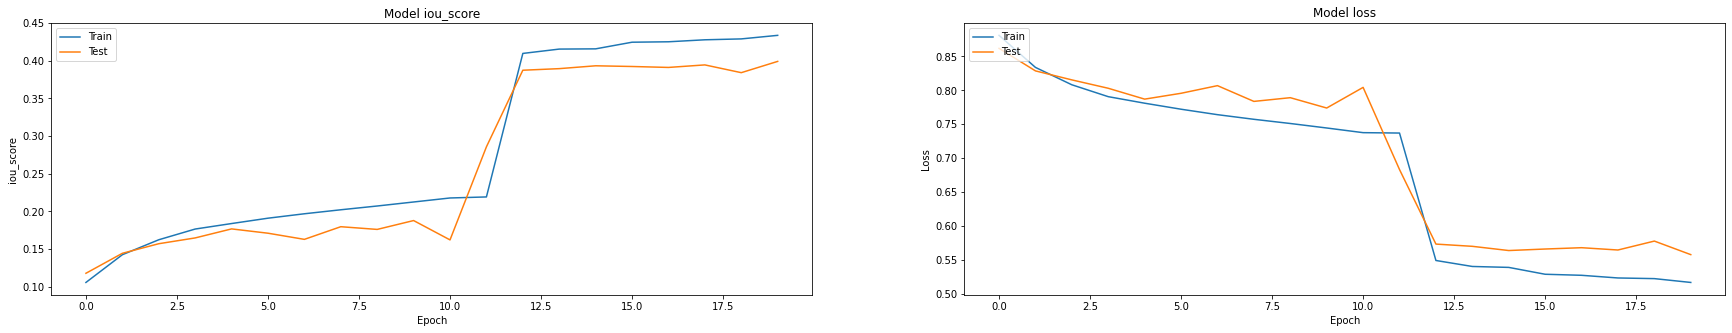

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
metrics=[sm.metrics.IOUScore(threshold=0.5)]
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss: 0.55759
mean iou_score: 0.39922


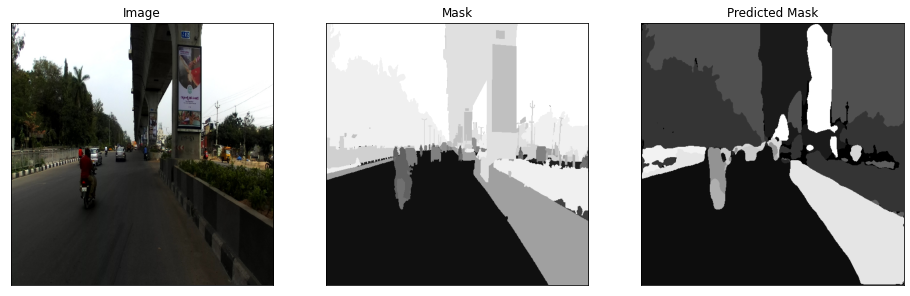

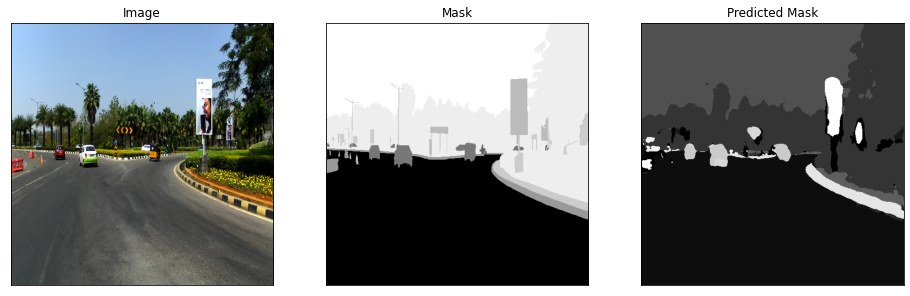

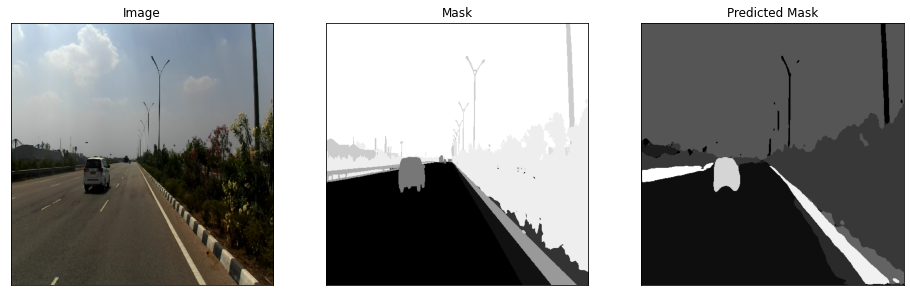

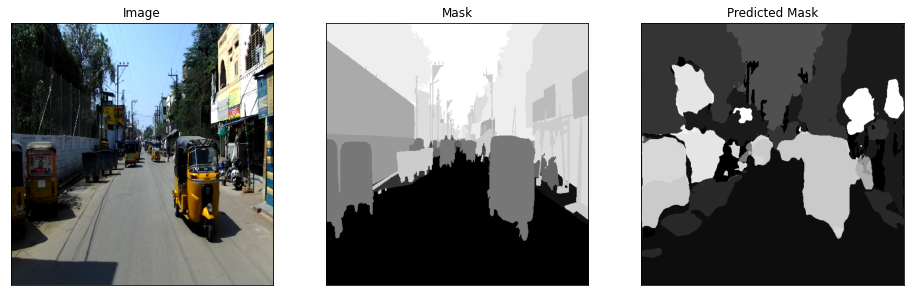

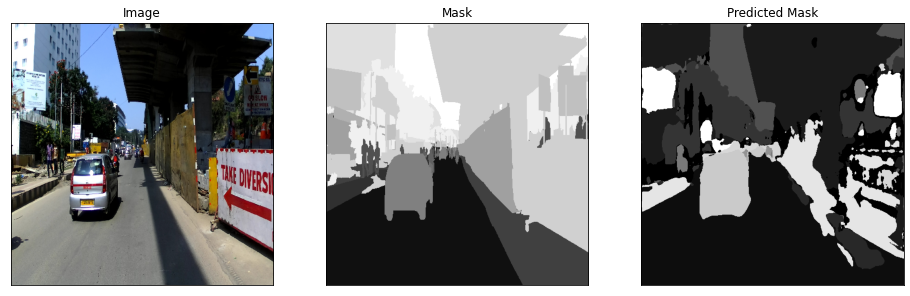

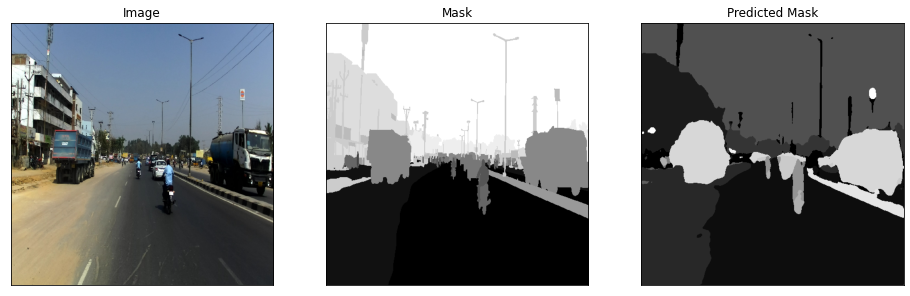

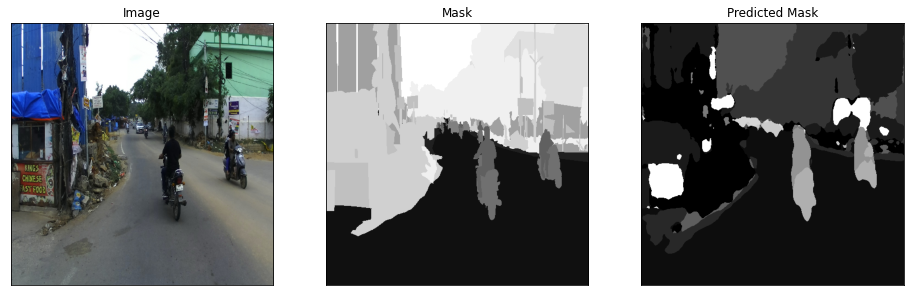

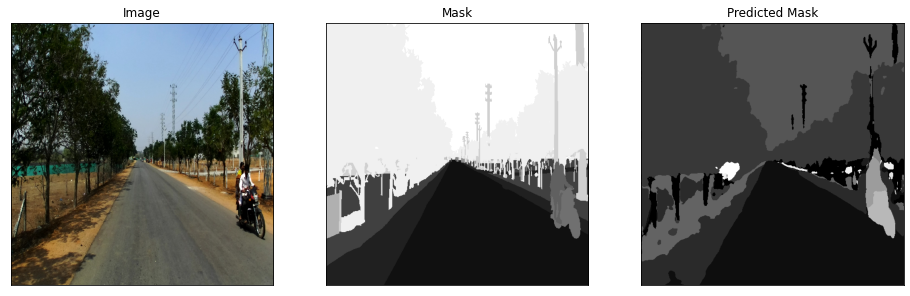

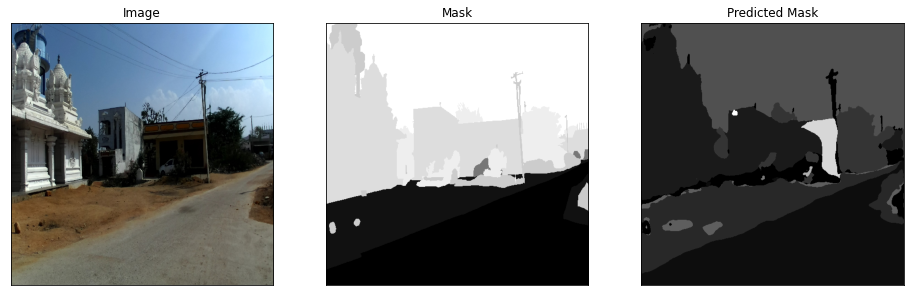

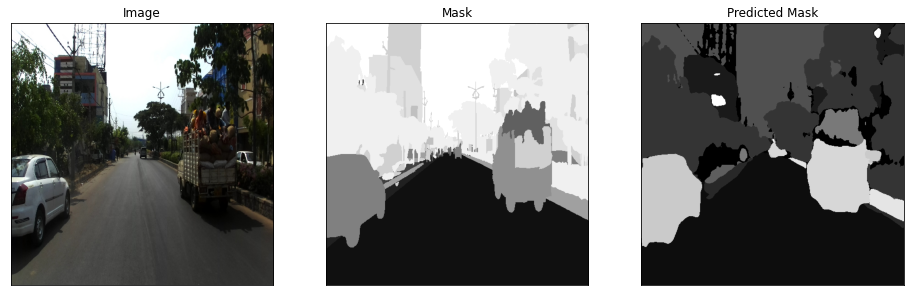

In [ ]:
x = test_x[11:21] 
y = test_y[11:21]
for i in range(len(x)): 
  #original image
  image = cv2.imread(x[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (512,512), interpolation=cv2.INTER_NEAREST)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = image/255.0

  #predicted segmentation map
  predicted  = model.predict(image[np.newaxis,:,:,:])
  predicted = np.argmax(predicted, axis=-1)
  predicted = np.expand_dims(predicted, axis=-1)
  # print(predicted.shape)
  
  #original segmentation map
  mask = cv2.imread(y[i], 0)
  mask = cv2.resize(mask, (512,512), interpolation=cv2.INTER_NEAREST)
  # print(mask.shape)

  visualize(
    image=image, 
    mask=mask,
    predicted_mask=predicted[..., 0].squeeze()
  )